# Feature Neutralization

In [1]:
# Install dependencies
!pip install -q numerapi pandas matplotlib lightgbm pyarrow cloudpickle

## 1. Feature Risk

Features can be predictive own their own, but not consistenty. This inconsistency is what we refer to as feature risk.

Let's evaluate the performance of each feature on their own to see if we can quantify this risk.

In [2]:
from numerapi import NumerAPI
import json
import pandas as pd

napi = NumerAPI()
napi.download_dataset("v4.1/train.parquet");
napi.download_dataset("v4.1/features.json");

feature_metadata = json.load(open("v4.1/features.json")) 
feature_cols = feature_metadata["feature_sets"]["small"]
training_data = pd.read_parquet("v4.1/train.parquet", columns=["era"] + feature_cols + ["target"])

2023-06-21 14:05:17,686 INFO numerapi.utils: target file already exists
2023-06-21 14:05:17,687 INFO numerapi.utils: download complete
2023-06-21 14:05:18,089 INFO numerapi.utils: target file already exists
2023-06-21 14:05:18,090 INFO numerapi.utils: download complete


In [3]:
from scipy import stats
import numpy as np

# Numerai's primary scoring metric
def numerai_corr(preds, target):
    # rank (keeping ties) then gaussianize predictions to standardize prediction distributions
    ranked_preds = (preds.rank(method="average").values - 0.5) / preds.count()
    gauss_ranked_preds = stats.norm.ppf(ranked_preds)
    # center targets around 0
    centered_target = target - target.mean()
    # raise both preds and target to the power of 1.5 to accentuate the tails
    preds_p15 = np.sign(gauss_ranked_preds) * np.abs(gauss_ranked_preds) ** 1.5
    target_p15 = np.sign(centered_target) * np.abs(centered_target) ** 1.5
    # finally return the Pearson correlation
    return np.corrcoef(preds_p15, target_p15)[0, 1]

In [4]:
# Compute the per-era correlation of each feature to the targete
per_era_corrs = pd.DataFrame(index=training_data.era.unique())
for feature_name in feature_cols:
    per_era_corrs[feature_name] = training_data.groupby("era").apply(lambda d: numerai_corr(d[feature_name], d["target"]))

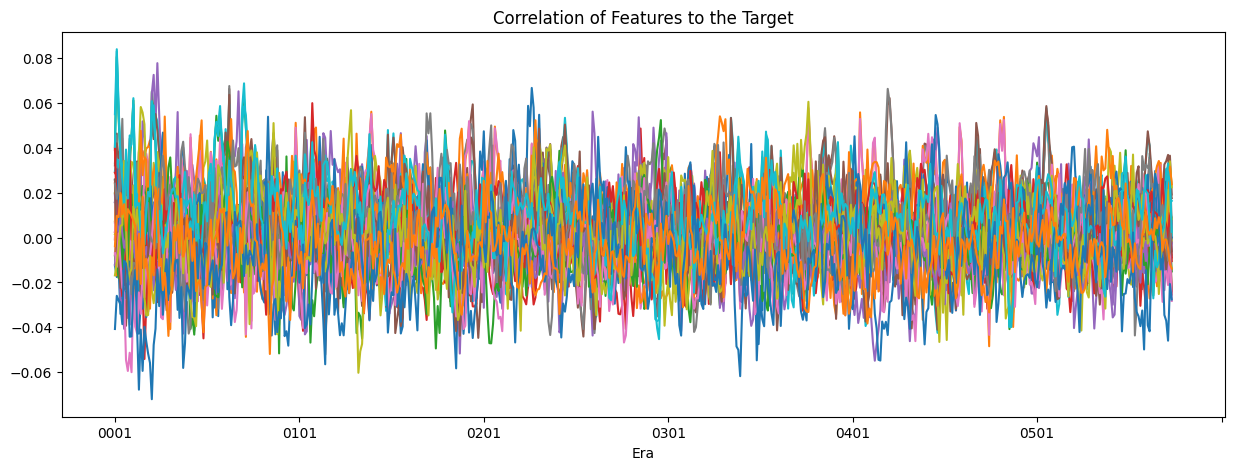

In [5]:
# Plot the per-era correlations of the features
per_era_corrs.plot(figsize=(15, 5), title="Correlation of Features to the Target", legend=False, xlabel="Era");

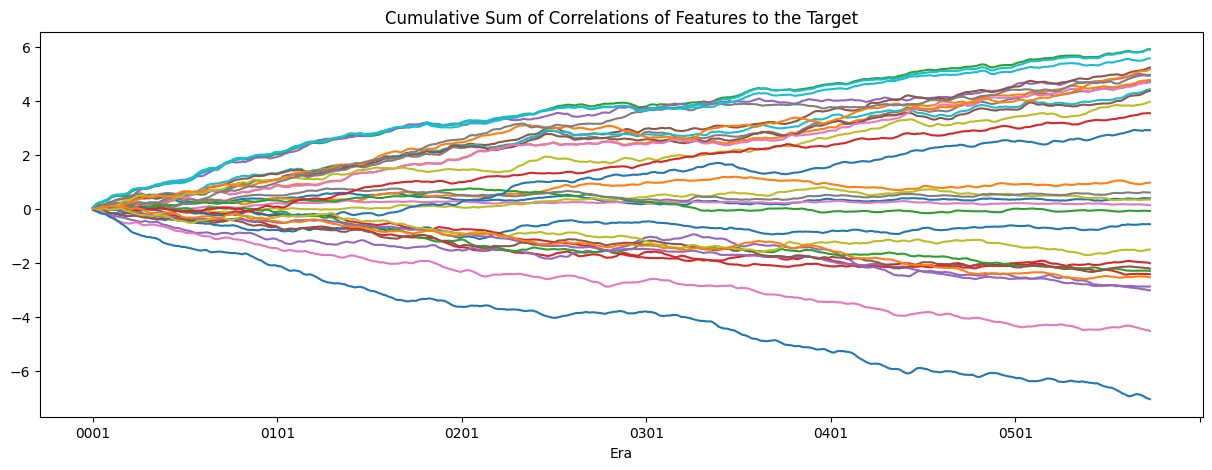

In [6]:
# Plot the cumulative sum of the per-era correlations of the features
per_era_corrs.cumsum().plot(figsize=(15, 5), title="Cumulative Sum of Correlations of Features to the Target", legend=False, xlabel="Era");

In [7]:
def metrics(per_era_corr):
    corr_mean = per_era_corr.mean()
    corr_std = per_era_corr.std(ddof=0)
    corr_sharpe = corr_mean / corr_std
    max_drawdown = -(per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

    eras = training_data.era.unique()
    corr_mean_first_half = per_era_corr.loc[eras[:len(eras)//2]].mean()
    corr_mean_second_half = per_era_corr.loc[eras[len(eras)//2:]].mean()
    delta = abs(corr_mean_first_half - corr_mean_second_half)

    return { "mean": corr_mean, "std": corr_std, "sharpe": corr_sharpe, "max_drawdown": max_drawdown, "delta": delta }

# compute performance metrics for each feature
feature_metrics = pd.DataFrame(index=feature_cols, columns=["mean", "std", "sharpe", "max_drawdown", "delta"])
for feature_name in feature_cols:
    feature_metrics.loc[feature_name] = metrics(per_era_corrs[feature_name])

# make all cells numeric 
feature_metrics = feature_metrics.apply(pd.to_numeric)

feature_metrics.sort_values("mean", ascending=False)

,mean,std,sharpe,max_drawdown,delta
feature_coraciiform_sciurine_reef,0.010305,0.015693,0.656670,-0.164262,0.006789
feature_piping_geotactic_cusp,0.010284,0.015753,0.652796,-0.179569,0.005983
feature_unsizable_ancestral_collocutor,0.009715,0.015981,0.607901,-0.204947,0.007183
feature_distressed_bloated_disquietude,0.009124,0.018104,0.503994,-0.268530,0.001863
feature_sodding_choosy_eruption,0.009009,0.018243,0.493818,-0.515897,0.002571
feature_cyclopedic_maestoso_daguerreotypist,0.008652,0.018057,0.479125,-0.187818,0.008906
feature_unpainted_censual_pinacoid,0.008607,0.016073,0.535502,-0.208227,0.006267
feature_fribble_gusseted_stickjaw,0.008319,0.016708,0.497914,-0.200807,0.000165
feature_elaborate_intimate_bor,0.008247,0.018632,0.442644,-0.306579,0.002554
feature_just_flavescent_draff,0.008163,0.016992,0.480431,-0.208231,0.000307


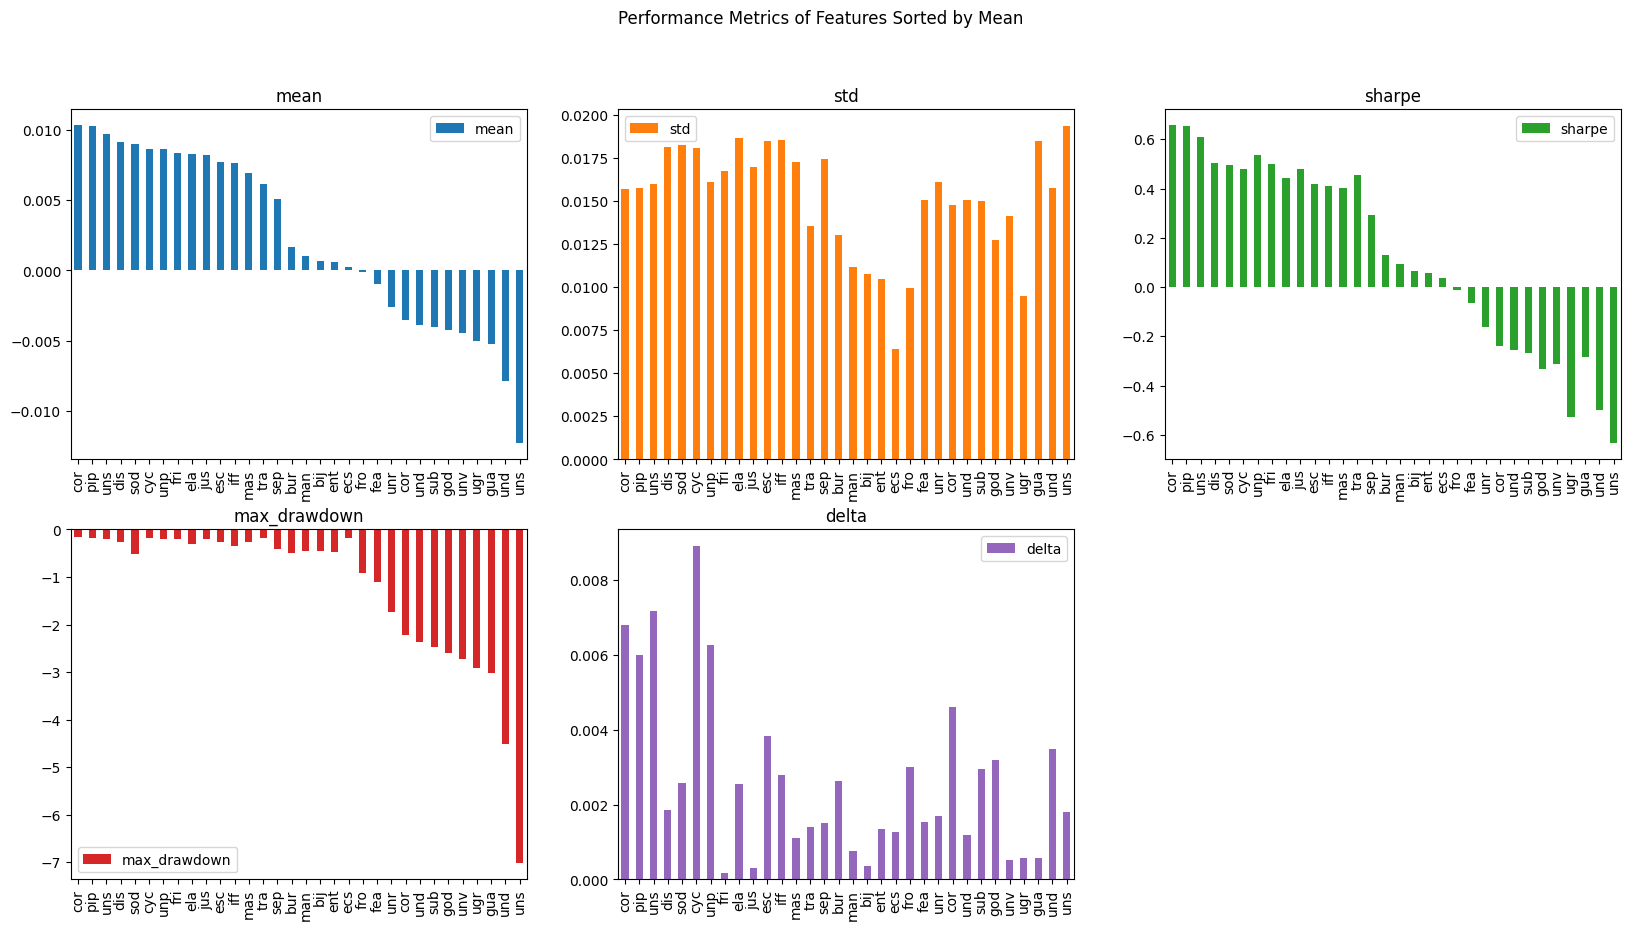

In [8]:
# make a copy of the feature metrics 
feature_metrics_copy = feature_metrics.copy()

# shorten the feature names by removing the prefix and taking the first 3 characters
feature_metrics_copy.index = feature_metrics_copy.index.str.replace("feature_", "")
feature_metrics_copy.index = feature_metrics_copy.index.str[:3]

# plot the performance metrics of the features as bar charts sorted by mean
feature_metrics_copy.sort_values("mean", ascending=False).plot.bar(
    subplots=True, figsize=(20, 10), layout=(2, 3), sharex=False, title="Performance Metrics of Features Sorted by Mean"
);

The bar charts above show the performance metrics of each feature in the training data computed
- `mean` mean of per era correlations
- `std` standard deviation of per era correlations
- `sharpe` standard deviation adjusted mean of per era correlations
- `max_drawdown` maximum peak to trough drop in cumulative per era correlation 
- `delta` the absolute delta between the first and second half of eras

The most obvious observation is that `mean`, `sharpe`, and `max_drawdown` seem to all tell the same story - features with the highest sharpe also have the highest mean and lowest max drawdown, features with the lowest mean tend to have the lowest sharpe and highest max drawdown. This should be intuitive given how these three metrics are computed. 

But just because a feature has a negative `mean` does not neccesarily make it risky. When talking about feature risk, it may be more helpful to consider `std` and `delta`.

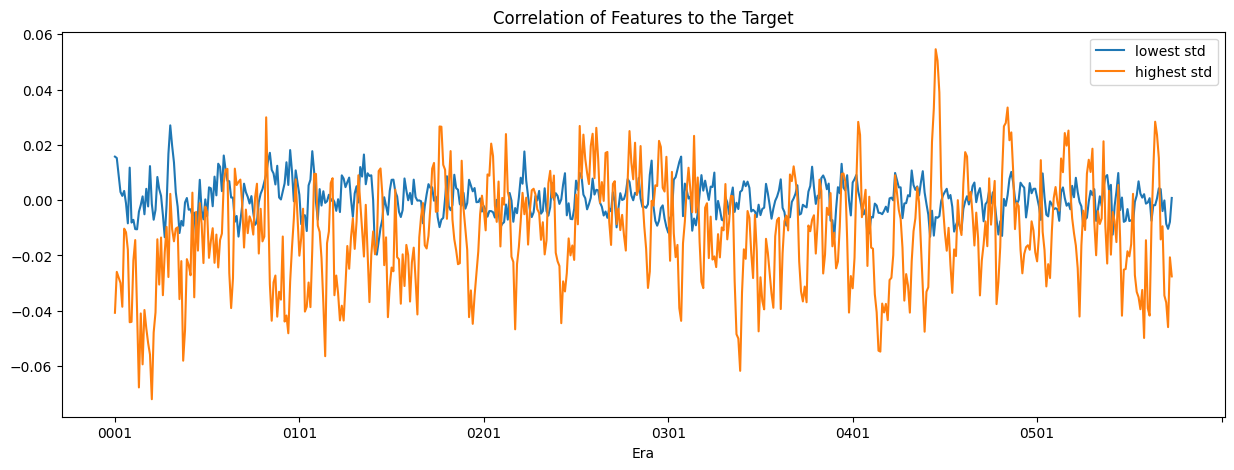

In [9]:
import matplotlib.pyplot as plt
# plot the per era correlation of the feature with the lowest delta
per_era_corrs[[feature_metrics["std"].idxmin(), feature_metrics["std"].idxmax()]].plot(
    figsize=(15, 5), title="Correlation of Features to the Target", xlabel="Era"
) 
plt.legend(["lowest std", "highest std"]);

Above is a comparison of the highest and lowest `std` features. Which one looks more risky to you and why?

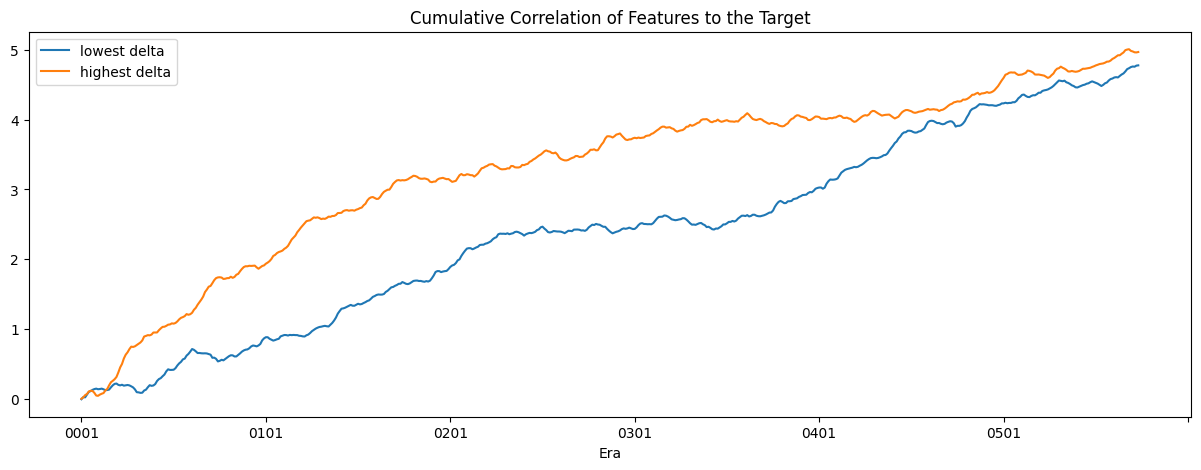

In [10]:
# plot the per era correlation of the feature with the lowest delta
per_era_corrs[[feature_metrics["delta"].idxmin(), feature_metrics["delta"].idxmax()]].cumsum().plot(
    figsize=(15, 5), title="Cumulative Correlation of Features to the Target", xlabel="Era"
) 
# label as "most stable" and "least stable"
plt.legend(["lowest delta", "highest delta"]);

Above is a comparison of the highest and lowest `delta` features. Which one looks more risky to you and why?

# Feature Exposure

`Feature exposure` is a measure of a model's exposure to feature risk. 

One simple measure of feature exposure is the Pearson correlation between a model's predictions and each feature. 

Let's train a model, make some predictions on the validation set, and measure its feature exposure.

In [11]:
import lightgbm as lgb

try: 
  model = lgb.Booster(model_file='small_lgb.model');
except lgb.basic.LightGBMError:
  model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    num_leaves=2 ** 5,
    colsample_bytree=0.1
  )
  model.fit(
    training_data[feature_cols],
    training_data["target"]
  );
  model.booster_.save_model("small_lgb.model");

In [12]:
# Download validation data 
# This will take about 2 minutes 🍵
napi.download_dataset("v4.1/validation.parquet");

# Load the validation data but only the "small" subset of features
validation_data = pd.read_parquet("v4.1/validation.parquet", columns=["era", "data_type"] + feature_cols + ["target"]) 

# Filter for data_type == "validation"
validation_data = validation_data[validation_data["data_type"] == "validation"]
del validation_data["data_type"]

# Generate predictions against the out of sample validation features
# This will take about 2 minutes 🍵
validation_data["prediction"] = model.predict(validation_data[feature_cols])

2023-06-21 14:06:11,260 INFO numerapi.utils: target file already exists
2023-06-21 14:06:11,262 INFO numerapi.utils: download complete


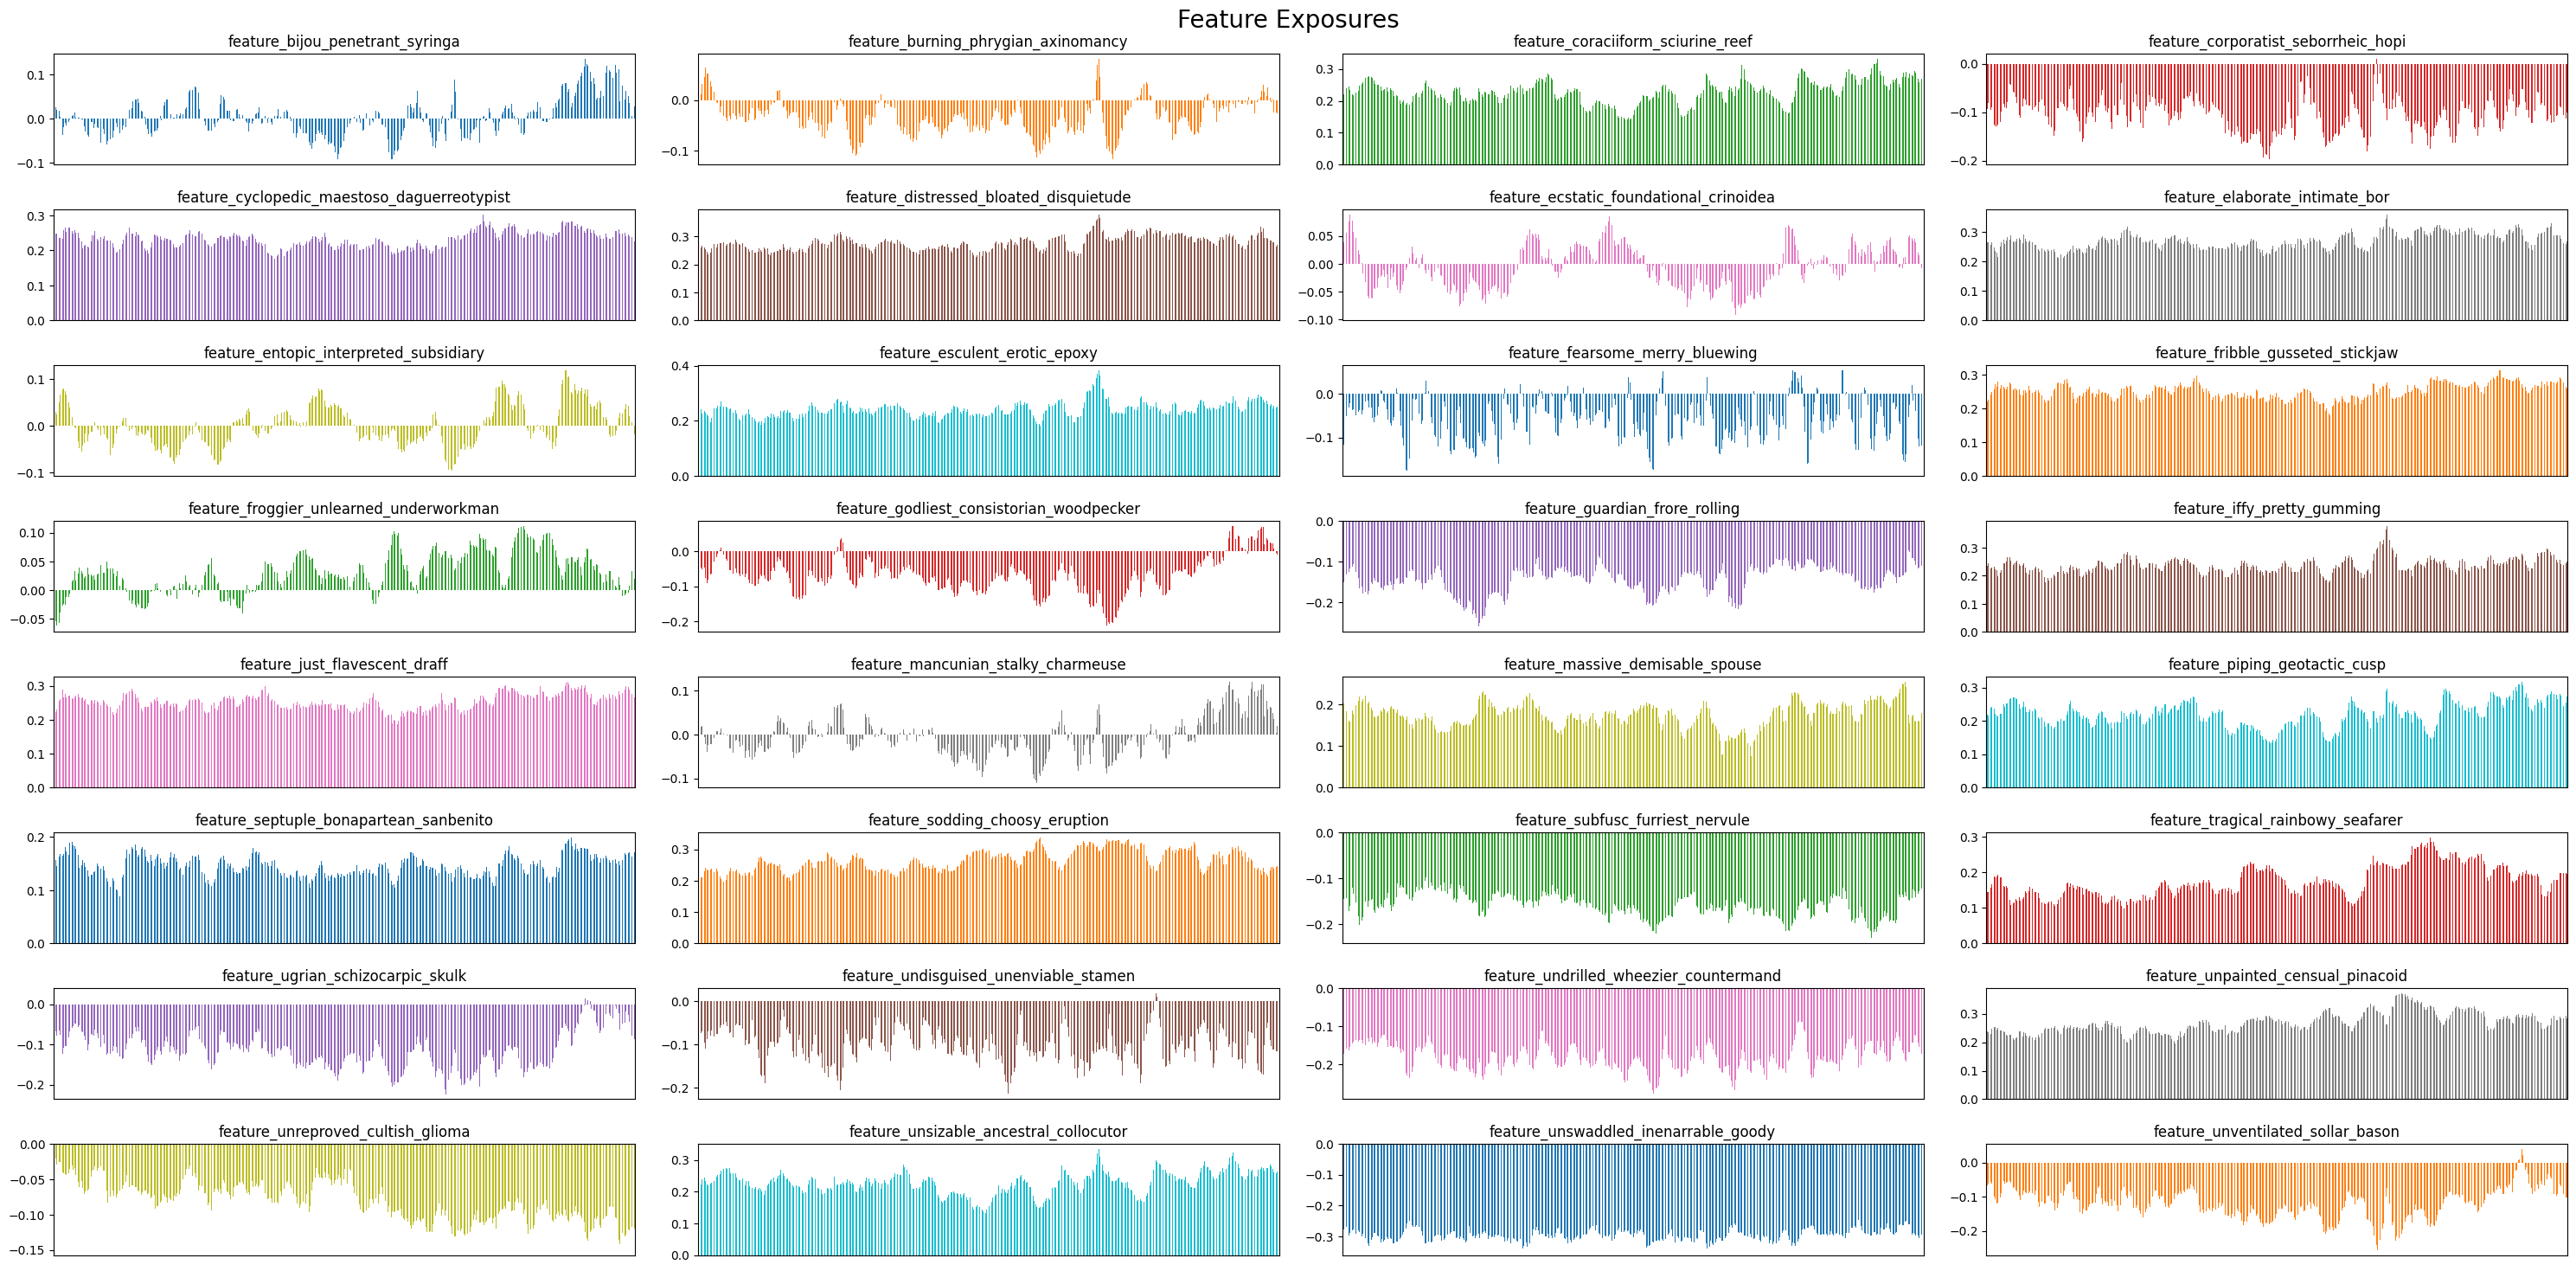

In [13]:
# compute the peason correlation of the predictions with each feature
feature_exposures = validation_data.groupby("era").apply(lambda d: d[feature_cols].corrwith(d["prediction"]))

# plot the feature exposures as bar charts 
feature_exposures.plot.bar(
    subplots=True, figsize=(30, 15), layout=(8, 4), sharex=False, title="Feature Exposures", xticks=[], legend=False
);
# remove title for each chart
for ax in plt.gcf().axes:
    ax.set_xlabel("")
# reduce padding between title and charts 
plt.tight_layout(pad=1.5)
# increase font size of main title 
plt.gcf().suptitle("Feature Exposures", fontsize=20);

In the charts above, we can see the exposures our model has to each feature. 

Our model seems to be consistently positively or negative correlated to some features. But what will happen to our model's performance if these features suddenly reverse or stop working out of sample?

Another, perhaps more useful way to visualize the overall feature exposure of our model is to look at the per-era max feature exposure across all features. This is a simple way for us to estimate the maximum feature risk we are exposed to across all features.

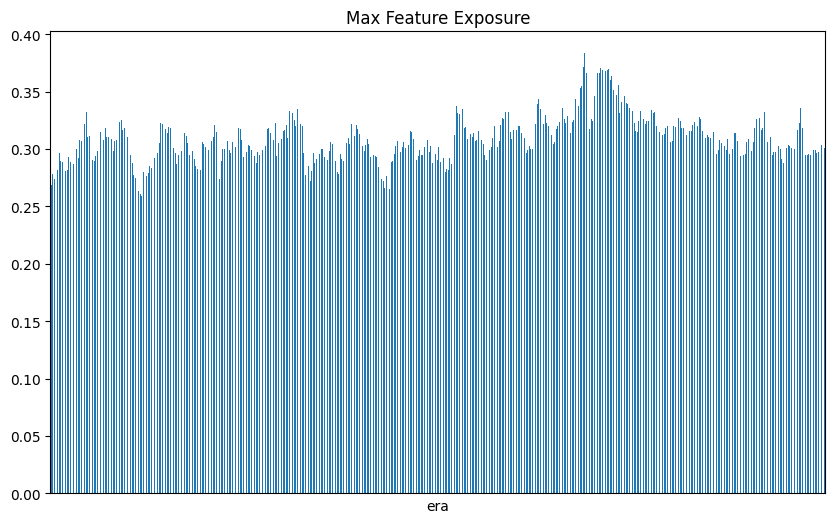

In [14]:
# Plot the max feature exposure per era
max_feature_expposure_per_era = validation_data.groupby("era").apply(lambda d: d[feature_cols].corrwith(d["prediction"]).abs().max())
max_feature_expposure_per_era.plot(title="Max Feature Exposure", kind="bar", figsize=(10, 6), xticks=[]);

In [15]:
# Mean max feature exposure across eras
max_feature_exposure_mean = max_feature_expposure_per_era.mean()
max_feature_exposure_mean

0.30851654483757246

## Feature Neutralization

`Feature Neutralization` is a way to reduce `Feature Exposure`. 

Let's try to neutralize our predictions to the features and see how that affects the performance of our model.

In [16]:
# Neutralize predictions to features
def neutralize(predictions: pd.DataFrame, features: list[str], proportion: float = 1.0) -> pd.DataFrame:
    # add a constant term the features so we can fit the bias/offset term
    features = np.hstack((features, np.array([np.mean(predictions)] * len(features)).reshape(-1, 1)))    
    # remove the parts of the predictions that are linearly correlated with features
    predictions -= proportion * features @ (np.linalg.pinv(features, rcond=1e-6) @ predictions)
    # scale 
    return predictions.rank(method='first', pct=True)

In [17]:
# Neutralize predictions by 50% per-era againat all features
neutralized = validation_data.groupby("era").apply(lambda d: neutralize(d["prediction"], d[feature_cols], 0.75))

# Align the neutralized predictions with the validation data
validation_data["neutral_prediction"] = neutralized.reset_index().set_index("id")["prediction"]
validation_data[["era", "prediction", "neutral_prediction", "target"]]

,era,prediction,neutral_prediction,target
id,,,,
n000101811a8a843,0575,0.488841,0.011868,0.75
n001e1318d5072ac,0575,0.495411,0.152405,0.00
n002a9c5ab785cbb,0575,0.502395,0.972309,0.50
n002ccf6d0e8c5ad,0575,0.507658,0.911097,0.00
n0051ab821295c29,0575,0.486678,0.129294,0.50
...,...,...,...,...
nffdc59d43c7a749,1062,0.511512,0.758475,0.50
nffe2c4b26317ac0,1062,0.495930,0.236481,0.25
nfff76b497502e1c,1062,0.494379,0.116021,0.75


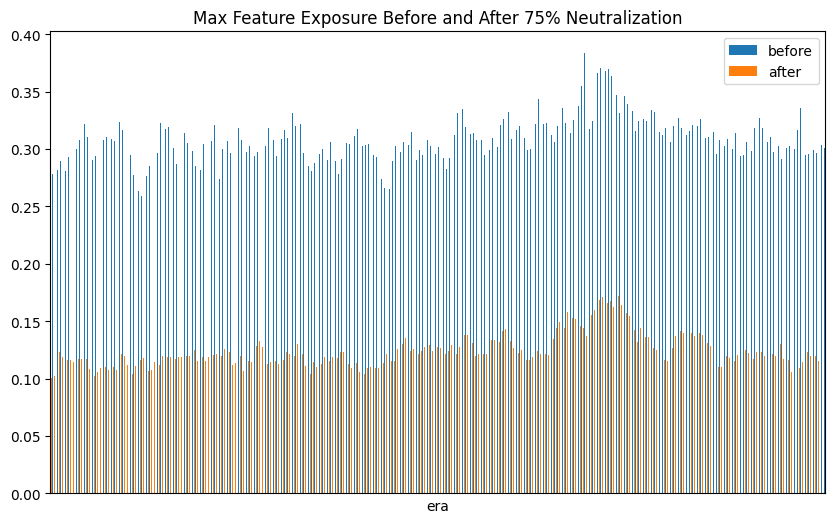

In [18]:
# Compute the per-era correlation between our neutralized predictions and the target values
max_feature_exposure_per_era_neutral = validation_data.groupby("era").apply(lambda d: d[feature_cols].corrwith(d["neutral_prediction"]).abs().max())

# Plot the max feature exposure per era before and after neutralization side by side 
pd.DataFrame({"before": max_feature_expposure_per_era, "after": max_feature_exposure_per_era_neutral}).plot(
    title="Max Feature Exposure Before and After 75% Neutralization", kind="bar", figsize=(10, 6), xticks=[]
);

Great! Looks like we have succesfully reduced our max feature exposure. Now let's check the other performance metrics before vs after neutralization.

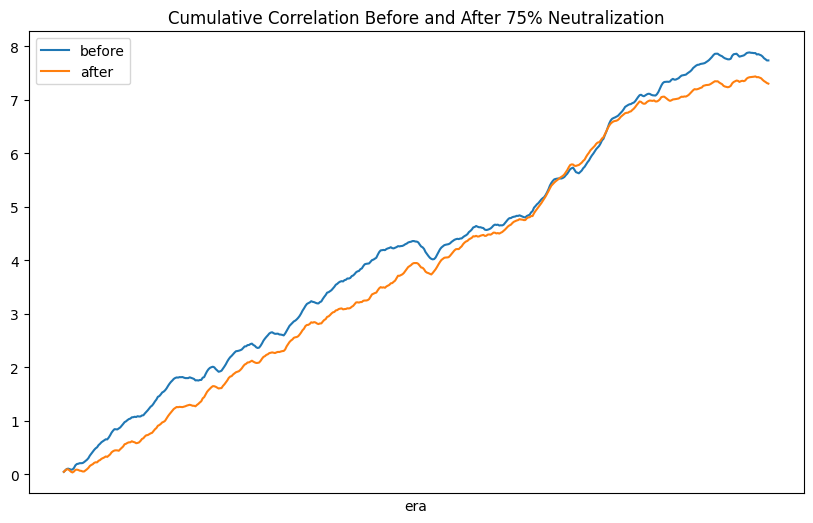

In [19]:
# Plot cumulative correlation before and after neutralization side by side
per_era_validation_correlation = validation_data.groupby("era").apply(lambda x: numerai_corr(x["prediction"], x["target"]))
per_era_validation_correlation_neutral = validation_data.groupby("era").apply(lambda x: numerai_corr(x["neutral_prediction"], x["target"]))
cumulative_per_era_validation_correlation = per_era_validation_correlation.cumsum()
cumulative_per_era_validation_correlation_neutral = per_era_validation_correlation_neutral.cumsum()
before_vs_after = pd.DataFrame({"before": cumulative_per_era_validation_correlation, "after": cumulative_per_era_validation_correlation_neutral})
before_vs_after.plot(title="Cumulative Correlation Before and After 75% Neutralization", figsize=(10, 6), xticks=[]);

In the chart above, it looks like feature neutralization has improved our model's consistency (straigher line) at the cost of performance (lower final point).

In [20]:
correlation_mean = per_era_validation_correlation.mean()
correlation_std = per_era_validation_correlation.std(ddof=0)
numerai_sharpe = correlation_mean / correlation_std
rolling_max = cumulative_per_era_validation_correlation.expanding(min_periods=1).max()
max_drawdown = (rolling_max - cumulative_per_era_validation_correlation).max()
max_feature_exposure_mean = max_feature_expposure_per_era.mean()

# Compute performance metrics after neutralization
correlation_mean_neutral = per_era_validation_correlation_neutral.mean()
correlation_std_neutral = per_era_validation_correlation_neutral.std(ddof=0)
numerai_sharpe_neutral = correlation_mean_neutral / correlation_std_neutral
rolling_max_neutral = cumulative_per_era_validation_correlation_neutral.expanding(min_periods=1).max()
max_drawdown_neutral = (rolling_max_neutral - cumulative_per_era_validation_correlation_neutral).max()
max_feature_exposure_mean_neutral = max_feature_exposure_per_era_neutral.mean()

# Display performance metrics before and after neutralization side by side
pd.DataFrame({
    "metric": ["correlation mean", "sharpe", "std", "max drawdown", "max feature exposure mean"],
    "before": [correlation_mean, numerai_sharpe, correlation_std, max_drawdown, max_feature_exposure_mean],
    "after": [correlation_mean_neutral, numerai_sharpe_neutral, correlation_std_neutral, max_drawdown_neutral, max_feature_exposure_mean_neutral],
    "% change": [
        100 * (correlation_mean_neutral - correlation_mean) / correlation_mean,
        100 * (numerai_sharpe_neutral - numerai_sharpe) / numerai_sharpe,
        100 * (correlation_std_neutral - correlation_std) / correlation_std,
        100 * (max_drawdown_neutral - max_drawdown) / max_drawdown,
        100 * (max_feature_exposure_mean_neutral - max_feature_exposure_mean) / max_feature_exposure_mean]
}).set_index("metric")

,before,after,% change
metric,,,
correlation mean,0.015856,0.014967,-5.609058
sharpe,0.741315,0.809044,9.136445
std,0.021390,0.018500,-13.511072
max drawdown,0.342537,0.213556,-37.654764
max feature exposure mean,0.308517,0.124056,-59.789366


We see this tradeoff between consistency and performance in the metrics above. The neutralized predictions have higher `sharpe` and lower `max drawdown` but lower `mean`. Does this tradeoff seem worth it to you?

In this example, we neutralized against all of the features we trained on with a proportion of 0.75. In practice, you may want to experiment with neutralizing against different subsets of features at different proportions. Ultimately, how you balance performance vs risk by applying feature neutralization is completely up to you. 

Feature neutralization is a deep and active area of research in the Numerai community. If you want to learn more about it, including the math behind the neutralization function, we highly encourage you to read up on the following posts: 
- https://forum.numer.ai/t/model-diagnostics-feature-exposure/899
- https://forum.numer.ai/t/an-introduction-to-feature-neutralization-exposure/4955

To wrap this chapter up, lets create and upload our second model prediction pipeline using feature neutralization.

In [25]:
def predict_neutral(live_features: pd.DataFrame) -> pd.DataFrame:
    live_predictions = model.predict(live_features[feature_cols])
    submission = pd.Series(live_predictions, index=live_features.index)
    # Neutralize to features by 75% 
    neutralized = neutralize(submission, live_features[feature_cols], 0.75)
    return neutralized.to_frame("prediction")

# Use the cloudpickle library to serialize your function and its dependencies
import cloudpickle
p = cloudpickle.dumps(predict_neutral)
with open("predict_neutral.pkl", "wb") as f:
    f.write(p)

In [22]:
# Download file if running in Google Colab
try:
    from google.colab import files
    files.download('predict_neutralclear.pkl')
except:
    pass

That's it! Now head back to [numer.ai](numer.ai) to upload your model prediction pipeline! 